# Team 17 Phase 1 Jupyter Notebook

#### Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
import matplotlib.image as mpimg

### Taking a look at input images

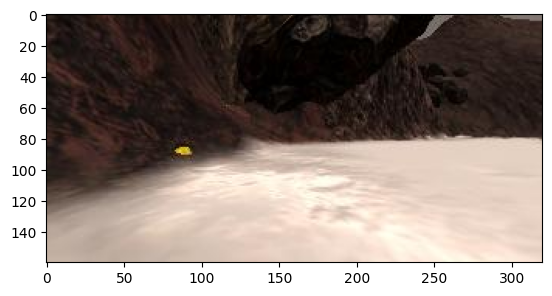

In [20]:
csvpath = '../test_dataset/robot_log.csv'
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth = cv2.merge((ground_truth,ground_truth,ground_truth))*0

file = open(csvpath, 'r')
csvreader = list(csv.reader(file, delimiter=';'))
row = csvreader[130]
impath = row[0]
imxp = np.float64(row[5]) # Position x
imyp = np.float64(row[6]) # Position y
imyaw = np.float64(row[8]) # Yaw
image = mpimg.imread(impath)
vision_image = cv2.imread(impath)

plt.imshow(image)

## Warping the Image

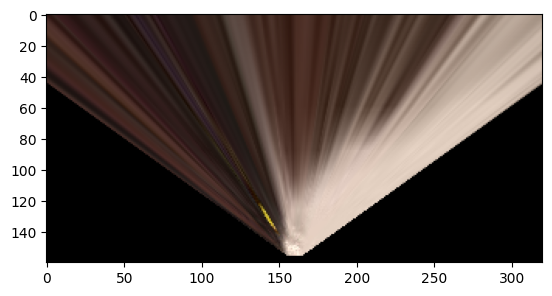

In [21]:
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped

dst_s = 5
bottom_offset = 5

source = np.float32([[14, 140],
                    [303, 140],
                    [200, 96],
                    [118, 96]])

destination = np.float32([[image.shape[1] / 2 - dst_s, image.shape[0] - bottom_offset],
                        [image.shape[1] / 2 + dst_s, image.shape[0] - bottom_offset],
                        [image.shape[1] / 2 + dst_s, image.shape[0] - 2*dst_s - bottom_offset],
                        [image.shape[1] / 2 - dst_s, image.shape[0] - 2*dst_s - bottom_offset]])

warped = perspect_transform(image, source, destination)
plt.imshow(warped)

## Creating a Mask for a more accurate thresholding for obstacles

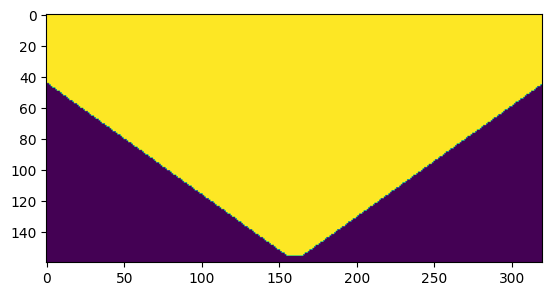

In [22]:
mask = np.ones_like(image[:,:,0], np.uint8)
mask = perspect_transform(mask, source, destination)
plt.imshow(mask)

## Applying a Threshold to find navigaitable terrain, obstacles and rocks

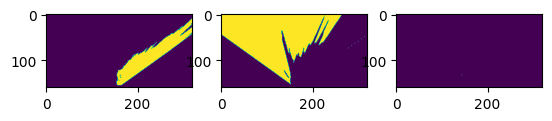

In [23]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    color_select[above_thresh] = 1
    return color_select

def obst_thresh(img, rgb_thresh=(100, 100, 100)):
    color_select = np.zeros_like(img[:,:,0])
    obs = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    color_select[obs] = 1
    return color_select

def rock_thresh(img, rgb_thresh=(95, 95, 20)):
    color_select = np.zeros_like(img[:,:,0])
    rocks = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    color_select[rocks] = 1
    return color_select

threshed = color_thresh(warped)
obstic = cv2.bitwise_and(obst_thresh(warped), mask)
rocks = rock_thresh(warped)

plt.subplot(131)
plt.imshow(threshed)
plt.subplot(132)
plt.imshow(obstic)
plt.subplot(133)
plt.imshow(rocks)

## Applying Thresholding to vision image for easy visualisation

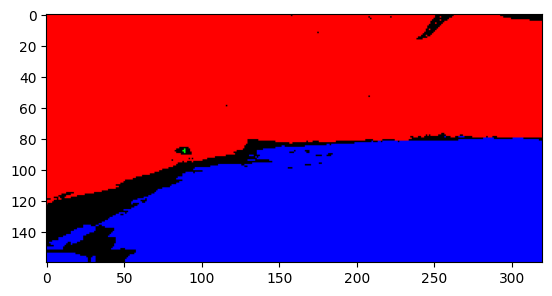

In [24]:
vision_image[:,:,2] = color_thresh(image)*255
vision_image[:,:,0] = obst_thresh(image)*255
vision_image[:,:,1] = rock_thresh(image)*255
plt.imshow(vision_image)

## Converting map image pixel values to rover-centric coords

In [26]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

xp, yp = rover_coords(threshed)
oxp, oyp = rover_coords(obstic)
rxp, ryp = rover_coords(rocks)

/tmp/ipykernel_5680/256472943.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_5680/256472943.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)


## Converting rover-centric pixel values to world coordinates

In [27]:
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

obstacle_x_world, obstacle_y_world = pix_to_world(oxp,oyp,imxp,imyp,imyaw,ground_truth.shape[0],2*dst_s)
rock_x_world, rock_y_world = pix_to_world(rxp,ryp,imxp,imyp,imyaw,ground_truth.shape[0],2*dst_s)
navigable_x_world, navigable_y_world = pix_to_world(xp,yp,imxp,imyp,imyaw,ground_truth.shape[0],2*dst_s)

## Updating Rover World Map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


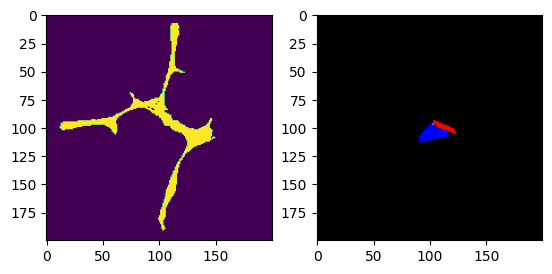

In [29]:
ground_truth[obstacle_y_world, obstacle_x_world, 2] = 255

ground_truth[rock_y_world, rock_x_world, 1] = 255

ground_truth[navigable_y_world, navigable_x_world, 0] = 255
ground_truth[navigable_y_world, navigable_x_world, 2] = 0

orgmap = mpimg.imread('../calibration_images/map_bw.png')

plt.subplot(121)
plt.imshow(orgmap)
plt.subplot(122)
plt.imshow(ground_truth)

## Rotating Image and drawing arrow of directon of movement for Debugging

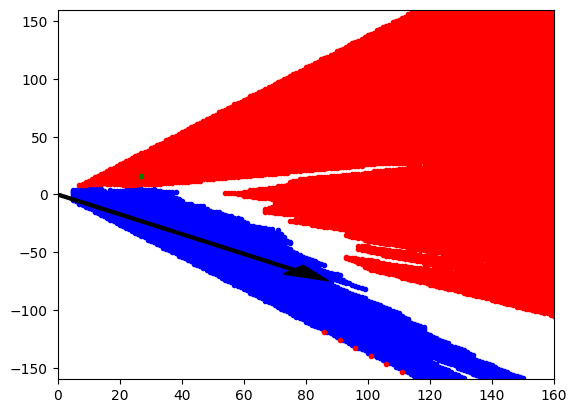

In [30]:
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

dist, angles = to_polar_coords(xp, yp)
arrow_length = 100
mean_dir = np.mean(angles)
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.plot(xp, yp, '.', color='blue')
plt.plot(oxp, oyp, '.', color='red')
plt.plot(rxp, ryp, '.', color='green')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='black', zorder=2, head_width=10, width=2)
plt.show()